<h2 style='color:blue' align='center'>Transfer learning in image classification</h2>

**In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand**

In [1]:
pip install tensorflow_hub


In [2]:
import numpy as np
import cv2
import PIL as PIL
import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Make predictions using ready made model (without any training)**

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda

# Define your image shape (height, width)
IMAGE_SHAPE = (224, 224)

# Load the pre-trained MobileNet V2 model from TensorFlow Hub
mobilenet_model = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4",
    input_shape=IMAGE_SHAPE+(3,),  # Specify input shape with color channels
    trainable=False  # Freeze the pre-trained weights
)

# Create a Sequential model
classifier = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: mobilenet_model.call(x))
])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


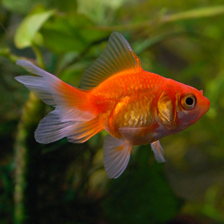

In [5]:
gold_fish = Image.open("/content/drive/MyDrive/Colab Notebooks/goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [6]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [7]:
gold_fish[np.newaxis, ...]

array([[[[0.28235294, 0.33333333, 0.07058824],
         [0.31372549, 0.37254902, 0.09019608],
         [0.34901961, 0.41960784, 0.11764706],
         ...,
         [0.32941176, 0.39215686, 0.00392157],
         [0.32156863, 0.38431373, 0.00392157],
         [0.30980392, 0.36862745, 0.        ]],

        [[0.28627451, 0.33333333, 0.08235294],
         [0.3254902 , 0.38039216, 0.10980392],
         [0.35294118, 0.42352941, 0.12941176],
         ...,
         [0.32156863, 0.38039216, 0.00392157],
         [0.31372549, 0.37254902, 0.00392157],
         [0.30196078, 0.36078431, 0.        ]],

        [[0.28627451, 0.33333333, 0.08627451],
         [0.31372549, 0.36862745, 0.10196078],
         [0.34509804, 0.41568627, 0.12941176],
         ...,
         [0.31764706, 0.37647059, 0.00392157],
         [0.30980392, 0.36862745, 0.00784314],
         [0.29803922, 0.35686275, 0.00392157]],

        ...,

        [[0.05490196, 0.10980392, 0.01568627],
         [0.05098039, 0.11372549, 0.01960784]

In [8]:
temp=gold_fish[np.newaxis, ...]

In [9]:
temp.shape

(1, 224, 224, 3)

In [10]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(1, 1001)

In [11]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [12]:
file_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
image_labels = []
with open(file_path, "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

10484/10484 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [13]:
image_labels[predicted_label_index]

'goldfish'

<h3 style='color:purple'>Load flowers dataset</h3>

In [14]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [15]:
data_dir

'./datasets/flower_photos'

In [16]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [17]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/sunflowers/1788133737_b1133d1aa7.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/4186808407_06688641e2_n.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/4940287066_385afd9c18_m.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/16967372357_15b1b9a812_n.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/10386525695_2c38fea555_n.jpg')]

In [18]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [19]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/5402157745_a384f0583d_n.jpg'),
 PosixPath('datasets/flower_photos/roses/15951588433_c0713cbfc6_m.jpg'),
 PosixPath('datasets/flower_photos/roses/3276552939_8c31b22d3e.jpg'),
 PosixPath('datasets/flower_photos/roses/12240165555_98625b1e88_n.jpg'),
 PosixPath('datasets/flower_photos/roses/8096324039_4db2555490.jpg')]

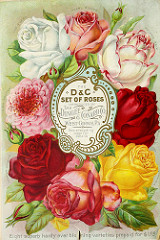

In [20]:
PIL.Image.open(str(roses[1]))

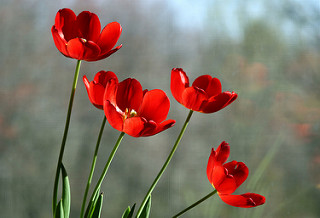

In [21]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

<h3 style='color:purple'>Read flowers images from disk into numpy array using opencv</h3>

In [22]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [23]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [24]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/5402157745_a384f0583d_n.jpg'),
 PosixPath('datasets/flower_photos/roses/15951588433_c0713cbfc6_m.jpg'),
 PosixPath('datasets/flower_photos/roses/3276552939_8c31b22d3e.jpg'),
 PosixPath('datasets/flower_photos/roses/12240165555_98625b1e88_n.jpg'),
 PosixPath('datasets/flower_photos/roses/8096324039_4db2555490.jpg')]

In [25]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/5402157745_a384f0583d_n.jpg'

In [26]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [27]:
img.shape

(222, 320, 3)

In [28]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [29]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [30]:
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images</h3>

In [32]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Make prediction using pre-trained model on new flowers dataset**

In [33]:
X[0].shape

(224, 224, 3)

In [34]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [35]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

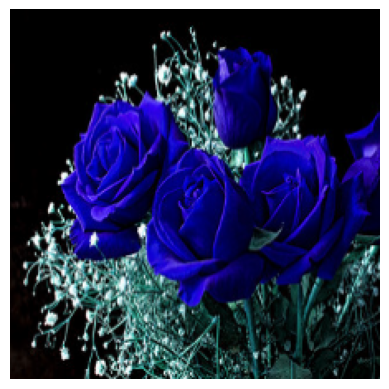

In [36]:
plt.axis('off')
plt.imshow(X[0])

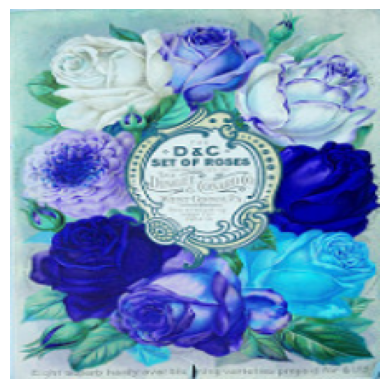

In [37]:
plt.axis('off')
plt.imshow(X[1])

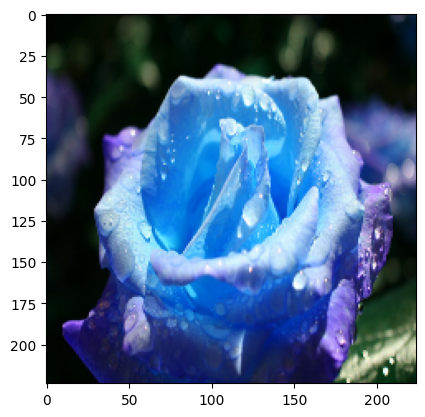

In [38]:
plt.imshow(X[2])

In [39]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


array([550, 795, 795])

In [40]:
image_labels[795]

'shower curtain'

<h3 style='color:purple'>Now take pre-trained model and retrain it using flowers images</h3>

In [41]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [42]:
import tf_keras
num_of_flowers = 5

model = tf_keras.Sequential([
  pretrained_model_without_top_layer,
  tf_keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [43]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=10, validation_split = 0.2, batch_size=64)

Epoch 1/10
35/35 [==============================] - 124s 3s/step - loss: 1.0651 - acc: 0.5770 - val_loss: 0.6415 - val_acc: 0.7659
Epoch 2/10
35/35 [==============================] - 98s 3s/step - loss: 0.5237 - acc: 0.8214 - val_loss: 0.4962 - val_acc: 0.8131
Epoch 3/10
35/35 [==============================] - 98s 3s/step - loss: 0.4162 - acc: 0.8632 - val_loss: 0.4276 - val_acc: 0.8530
Epoch 4/10
35/35 [==============================] - 98s 3s/step - loss: 0.3425 - acc: 0.8941 - val_loss: 0.3822 - val_acc: 0.8820
Epoch 5/10
35/35 [==============================] - 99s 3s/step - loss: 0.3073 - acc: 0.9064 - val_loss: 0.3725 - val_acc: 0.8675
Epoch 6/10
35/35 [==============================] - 118s 3s/step - loss: 0.2695 - acc: 0.9191 - val_loss: 0.3571 - val_acc: 0.8857
Epoch 7/10
35/35 [==============================] - 99s 3s/step - loss: 0.2414 - acc: 0.9309 - val_loss: 0.3450 - val_acc: 0.8838
Epoch 8/10
35/35 [==============================] - 99s 3s/step - loss: 0.2219 - acc: 0.

In [44]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 27s 946ms/step - loss: 0.3709 - acc: 0.8758


[0.3708663880825043, 0.8758170008659363]

In [45]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1] range
    return img_array

In [47]:
test_image_path = '/content/drive/MyDrive/Colab Notebooks/sun.jpg'
test_image = preprocess_image(test_image_path)
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted class: {predicted_class}")

# Example class names (should match your dataset structure)
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print(f"Predicted flower: {class_names[predicted_class[0]]}")

1/1 [==============================] - 1s 659ms/step
Predicted class: [3]
Predicted flower: sunflowers
